<a href="https://colab.research.google.com/github/Pasewark/LSC/blob/main/random_data_and_templates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install geotorch
!pip install git+https://github.com/Lezcano/geotorch/


  Cloning https://github.com/Lezcano/geotorch/ to /tmp/pip-req-build-urbux_dr
  Running command git clone -q https://github.com/Lezcano/geotorch/ /tmp/pip-req-build-urbux_dr
  Created wheel for geotorch: filename=geotorch-0.2.0-py3-none-any.whl size=58703 sha256=765b775bf6e87ddfcf6a51d652dafc61450c0a139bea31053239b32e5b5f5aec
  Stored in directory: /tmp/pip-ephem-wheel-cache-mqb9red7/wheels/3c/96/d6/4e2a53fc6cf0a50c5c08318205d4c5bf815216196aafcc86cb
Successfully built geotorch


In [ ]:
# download the LSC code from the paper
# need to move the files into the working directory after download
!git clone https://github.com/hchau630/LSC.git
!cp LSC/lsc.py lsc.py
!cp LSC/sc.py sc.py
!cp LSC/utils.py utils.py
!cp LSC/image_transform.py image_transform.py

Cloning into 'LSC'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 645 (delta 6), reused 7 (delta 2), pack-reused 624
Receiving objects: 100% (645/645), 432.11 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.nn as nn
import importlib
import torchvision
import torchvision.datasets as datasets
import time
import lsc
import sc
import matplotlib.animation as animation
import utils
import image_transform as img_tran
import os
import shutil
import geotorch
from torchvision.transforms import RandomErasing
import torchvision.transforms.functional as tvF


In [ ]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.cuda.set_device(0) #use GPU 0

In [ ]:
def plot_psi(psi, rgb=False, show=False, save=None, box_margins=[0.05,0.95,0.95,0.05]):
    fig = plt.figure(figsize=(10,int(K/10)))
    for k in range(K):
        fig.add_subplot(int(K/10),10,k+1)
        plt.xticks([])
        plt.yticks([])
        if rgb:
            plt.imshow((psi[:,k]/psi[:,k].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
        else:
            plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)

def plot_w(w, rgb=False, show=False, save=None, cols=16):
    fig = plt.figure(figsize=(cols,int(L*2/cols)))
    for i in range(L*2):
        fig.add_subplot(int(L*2/cols),cols,i+1)
        plt.xticks([])
        plt.yticks([])
        if rgb:
            plt.imshow((w[:,i]/w[:,i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
        else:
            plt.imshow(w[:,i].reshape(dim,dim).cpu(), cmap="Greys")
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def plot_operator(s_ratio, show=False, save=None, use_psi=False, rgb=False, rmin=-np.pi, rmax=np.pi, N_figs=19, K=10, box_margins=[0.05,0.95,0.95,0.05], hspace=0.0,wspace=0.0):
    if use_psi:
        x = psi[:,:K].clone().t()
    else:
        x = next(iter(test_dl))[:K]

    w1, w2 = w[:,::2], w[:,1::2] # (D,L), (D,L)
    u1 = torch.einsum('dj, bd -> bj', w1, x) # (B,L)
    u2 = torch.einsum('dj, bd -> bj', w2, x) # (B,L)

    y_hat = torch.zeros(K,N_figs,D)
    for j in range(N_figs):
        s = torch.from_numpy(np.array(s_ratio)*np.linspace(rmin, rmax, num=N_figs)[j]).cuda()
        m_hat = torch.einsum('jn,n->j',omega.float(), s.float())
        ru1, ru2 = lsc.rot(m_hat.float(), u1, u2)
        ru = torch.zeros((K,L*2)).cuda() # (K,L*2) = (B,L*2)
        ru[:,::2] = ru1
        ru[:,1::2] = ru2
        y_hat[:,j,:] = torch.einsum('dj, bj -> bd', w, ru) # (B,D)

    fig = plt.figure(figsize=(N_figs,K))
    for i in range(K):
        for j in range(N_figs):
            fig.add_subplot(K,N_figs,i*N_figs+j+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y_hat[i,j]/y_hat[i,j].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y_hat[i,j].reshape(dim,dim).cpu(), cmap="Greys", vmin=y_hat[:,j].min().cpu(), vmax=y_hat[:,j].max().cpu())
#     plt.tight_layout()
    plt.subplots_adjust(wspace=wspace,hspace=hspace,left=box_margins[0],right=box_margins[1],top=box_margins[2],bottom=box_margins[3])
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def plot_reconstruction(dl, alpha_0=0.01, show=False, save=None, three_d=False, plot_marginals=False,rgb=False,N=100,expanded=False,M=30):
    # Generate Data
    y = next(iter(dl))[:M]
    if k is not None and m is not None:
        mod_k, mod_m = k[:M], m[:M]
    else:
        mod_k, mod_m = None, None

    alpha = torch.ones(M,K).cuda()*alpha_0
    alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

    # Calculate useful variables (This and following parts total: 0.015s)
    x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)
    
    nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
    
    unique_omega = torch.unique(omega, dim=0) # (L,n)
    post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N) # (M,N,N)
    s_hat = utils.get_MAP(post)
    recon = lsc.reconstruct(x, w, s_hat, omega)
    
    if expanded:
        cols = 3+omega.size()[1]+psi.size()[1]
        fig = plt.figure(figsize=(cols,M))
        for i in range(M):
            fig.add_subplot(M,cols,i*cols+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(M,cols,i*cols+1+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
            for j in range(omega.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+j+1)
                plt.xticks(ticks=[-np.pi,0,np.pi],labels=[r'$-\pi$',0,r'$\pi$'])
                plt.yticks([])
                plt.plot(t,marginals[i,:,j])
            fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(torch.einsum('dk,k->d',psi,alpha[i]).cpu().reshape((dim,dim)),cmap="Greys")
            vmin, vmax = torch.min(torch.einsum('dk,k->dk',psi,alpha[i])), torch.max(torch.einsum('dk,k->dk',psi,alpha[i]))
            for j in range(psi.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1+j+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(psi[:,j].cpu().reshape((dim,dim))*alpha[i,j],vmin=vmin,vmax=vmax,cmap="Greys")
        plt.tight_layout(h_pad=0.0,w_pad=0.0)
    else:
        if three_d:
            tx, ty = np.linspace(-np.pi, np.pi, num=post.shape[1]), np.linspace(-np.pi, np.pi, num=post.shape[2])
            gx, gy = np.meshgrid(tx, ty)
        if plot_marginals:
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
        nfigs = 4 + omega.size()[1] if plot_marginals else 5
        cols = nfigs*3
        fig = plt.figure(figsize=(cols,10))
        for i in range(M):
            fig.add_subplot(10,cols,i*nfigs+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y[i]/y[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+2)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((recon[i]/recon[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+3)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((x[i]/x[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(x[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+4)
            plt.xticks([])
            plt.yticks([])
            plt.bar(np.arange(alpha.size()[1]), alpha[i].cpu())
            if three_d:
                ax = fig.add_subplot(10,cols,i*nfigs+5, projection='3d')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                ax.plot_surface(gx, gy, post[i])
            elif plot_marginals:
    #             print(marginals.shape)
                for j in range(omega.size()[1]):
                    fig.add_subplot(10,cols,i*nfigs+5+j)
                    plt.yticks([])
                    plt.plot(t,marginals[i,:,j])
            else:
                fig.add_subplot(10,cols,i*nfigs+5)
                plt.xticks([])
                plt.yticks([])
                plt.bar(np.arange(s_hat.size()[1]), s_hat[i].cpu())
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def save_loss(train_loss, test_loss, save):
    f = open(save, 'a')
    np.savetxt(f, np.array([train_loss, test_loss])[np.newaxis,:])
    f.close()
    
def plot_loss(load,show=True,save=None,validation_only=True):
    losses = np.loadtxt(load)
    train_loss, test_loss = losses[:,0], losses[:,1]
    eps = len(train_loss)
    if validation_only:
        plt.plot(np.arange(eps),test_loss,label="Validation Loss")
    else:
        plt.plot(np.arange(eps),train_loss,label="Training Loss")
        plt.plot(np.arange(eps),test_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Negative Log Likelihood)")
    if save:
        plt.savefig(save)
    if show:
        plt.show()
        
def get_MNIST_dataloader(B, cuda=False, dim=28):
    # Load mnist dataset.
#     transform = torchvision.transforms.Compose([
#         torchvision.transforms.ToTensor()
#     ])
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((dim,dim)),
        torchvision.transforms.ToTensor()
    ])
    mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
    mnist_testset = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)
    trainset_size = len(mnist_trainset)
    testset_size = len(mnist_testset)
    train_dl = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=trainset_size, shuffle=True)
    test_dl = torch.utils.data.DataLoader(dataset=mnist_testset, batch_size=testset_size, shuffle=True)
    
    num_train_batches, num_test_batches = trainset_size//B, testset_size//B
    assert num_train_batches*B == trainset_size
    assert num_test_batches*B == testset_size
    
    dim = next(iter(train_dl))[0].squeeze().size()[1]
    D = dim*dim
    new_train_dl = next(iter(train_dl))[0].squeeze().view(num_train_batches,B,D).cuda()
    new_test_dl = next(iter(test_dl))[0].squeeze().view(num_test_batches,B,D).cuda()
    
    new_train_dl = f.normalize(new_train_dl,dim=2)
    new_test_dl = f.normalize(new_test_dl,dim=2)
    
    if cuda:
        return new_train_dl, new_test_dl, dim, D, num_train_batches, num_test_batches
    else:
        return new_train_dl.cpu(), new_test_dl.cpu(), dim, D, num_train_batches, num_test_batches
    
class CustomDataLoader:
    def __init__(self, dataloader, B, D):
        self.dataloader = dataloader
        self.B = B
        self.D = D
    def __iter__(self):
        self.it = iter(self.dataloader)
        return self
    def __next__(self):
        try:
            batch = next(self.it)[0].view(self.B,self.D).cuda()
            return f.normalize(batch,dim=1)
        except StopIteration:
            raise StopIteration
            
def get_custom_dataloader(B, train_l=6000, test_l=1000, dx=[0.0,0.0], dy=[0.0,0.0], dr=[0.0,0.0], ds=[1.0,1.0], thicken=False, wrap=False, shuffle=True, cuda=False, dim=28):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((dim,dim)),
        torchvision.transforms.ToTensor()
    ])
    mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
    mnist_dl = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=1000, shuffle=False)
    batch = next(iter(mnist_dl))
    y = batch[0].squeeze() # (1000,dim,dim)
    labels = batch[1] # (1000)
    dl_batch_size, dim = y.size()[0], y.size()[1]
    center = ((dim)/2,(dim)/2)
    D = dim*dim
    N = 10
    num_train_batches, num_test_batches = N*train_l//B, N*test_l//B
    assert num_train_batches*B == N*train_l
    assert num_test_batches*B == N*test_l
    
    y = y.view(dl_batch_size,D)
    digits = torch.zeros((N,D))
    for i in range(10):
        idx = labels == i
        digits[i*(N//10):(i+1)*(N//10)] = y[idx][:(N//10)]
#         digits[i:i+1] = y[idx][np.random.choice(len(y[idx]))]
    print(digits.shape)
    print(digits)
    for dig in digits:
        print('dig')
        plt.imshow(dig.reshape(dim,dim).cpu(), cmap="Greys")
        plt.show()
    digits=digits[0].reshape(1,-1).repeat(10,1)

    train_video = torch.zeros(N,train_l,D)
    for i, digit in enumerate(digits):
        shift_x = torch.from_numpy(np.random.uniform(dim*dx[0],dim*dx[1],train_l))
        shift_y = torch.from_numpy(np.random.uniform(dim*dy[0],dim*dy[1],train_l))
        rotation = torch.from_numpy(np.random.uniform(dr[0],dr[1],train_l))
        scaling = torch.from_numpy(np.random.uniform(ds[0],ds[1],train_l))
        x = digit.repeat(train_l,1).view(train_l,dim,dim)
        y = img_tran.affine_2D(x, shift_x, shift_y, rotation, scaling, wrap_around=wrap)
        if thicken:
            sigma = torch.from_numpy(np.random.uniform(0.01,1.0,train_l))
            y = img_tran.thicken(y, sigma)
        train_video[i] = y.view(train_l,D)
        
    test_video = torch.zeros(N,test_l,D)
    for i, digit in enumerate(digits):
        shift_x = torch.from_numpy(np.random.uniform(dim*dx[0],dim*dx[1],test_l))
        shift_y = torch.from_numpy(np.random.uniform(dim*dy[0],dim*dy[1],test_l))
        rotation = torch.from_numpy(np.random.uniform(dr[0],dr[1],test_l))
        scaling = torch.from_numpy(np.random.uniform(ds[0],ds[1],test_l))
        x = digit.repeat(test_l,1).view(test_l,dim,dim)
        y = img_tran.affine_2D(x, shift_x, shift_y, rotation, scaling, wrap_around=wrap)
        if thicken:
            sigma = torch.from_numpy(np.random.uniform(0.01,1.0,test_l))
            y = img_tran.thicken(y, sigma)
        test_video[i] = y.view(test_l,D)
    
    train_video = f.normalize(train_video.view(N*train_l,D).cuda(),dim=1)
    test_video = f.normalize(test_video.view(N*test_l,D).cuda(),dim=1)
    
    if shuffle:
        train_video = train_video[torch.randperm(N*train_l)]
        test_video = test_video[torch.randperm(N*test_l)]
    
    if cuda:
        return train_video.view(num_train_batches,B,D), test_video.view(num_test_batches,B,D), dim, D, num_train_batches, num_test_batches
    else:
        return train_video.view(num_train_batches,B,D).cpu(), test_video.view(num_test_batches,B,D).cpu(), dim, D, num_train_batches, num_test_batches
    
def initialize_omega(n, L, o_max, multiplicity):
    if n == 1:
        omega = torch.arange(o_max).cuda().int().unsqueeze(1) # (ceil(o_max),1)
    elif n == 2: # n == 2
        omega_x = torch.arange(o_max).cuda() # (ceil(o_max))
        omega_y = torch.arange(-int(o_max), o_max).cuda() # (2*ceil(o_max)-1)
        omega = torch.stack(torch.meshgrid(omega_x, omega_y),dim=2).view(-1,2) # get list of points
        omega = omega[omega.float().norm(dim=1) <= o_max] # select points inside circle with radius o_max
        omega = omega[(omega[:,1] >= 0) + (omega[:,0] != 0)] # remove points on y-axis with negative y coordinates
        # sort by radius first, then by angle
        omega = torch.from_numpy(np.array(sorted(omega.cpu().numpy(),key=lambda x: (np.sum(x**2),np.arctan2(x[1],x[0]))))).cuda().int()
    else:
        omega_n = torch.arange(-int(o_max), o_max).cuda().repeat(n,1) # (n,2*ceil(o_max)-1)
        omega = torch.stack(torch.meshgrid(*omega_n),dim=n).view(-1,n) # ((2*ceil(o_max)-1)^n,n)
        omega = omega[omega.float().norm(dim=1) <= o_max].cpu().numpy() # select points inside n-sphere with radius o_max
        filtered_omega = []
        for o in omega:
            if tuple(-o) not in filtered_omega:
                filtered_omega.append(tuple(o))
        omega = torch.from_numpy(np.array(sorted(np.array(filtered_omega),key=lambda x: np.sum(x**2)))).cuda().int()
    omega = omega.repeat_interleave(multiplicity,dim=0) # multiplicity of irreps
    omega = omega[:L] # select the first L points # (L,n)
    return omega

# Show custom dataset

torch.Size([10, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
dig


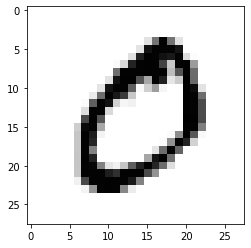

dig


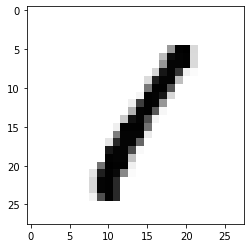

dig


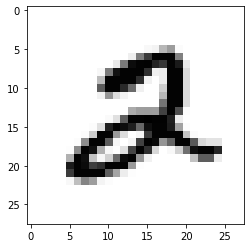

dig


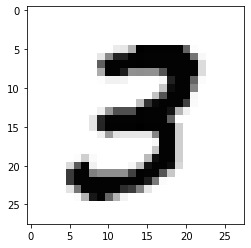

dig


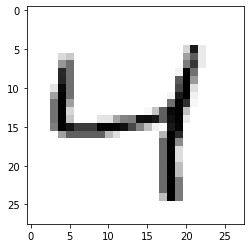

dig


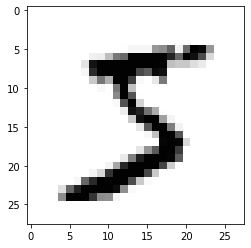

dig


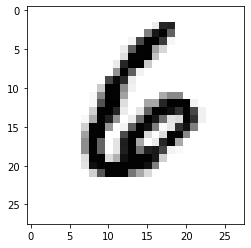

dig


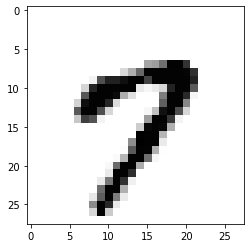

dig


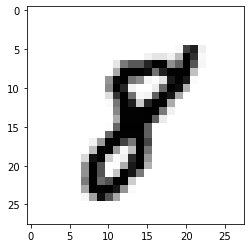

dig


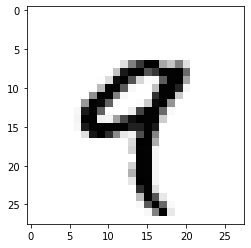

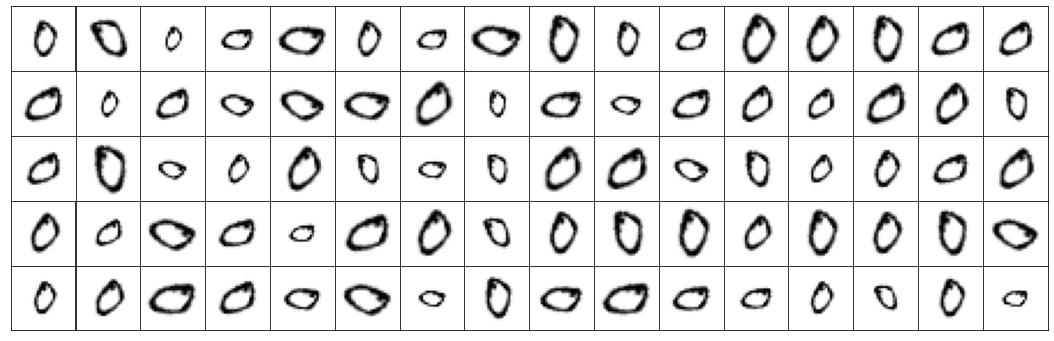

torch.Size([10, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
dig


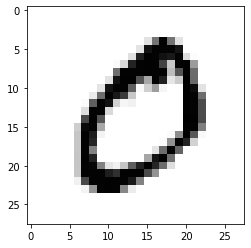

dig


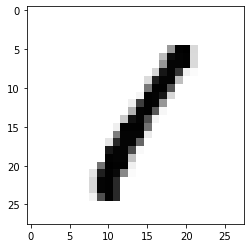

dig


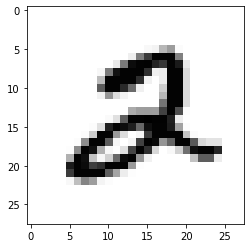

dig


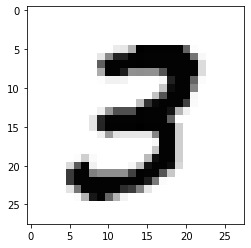

dig


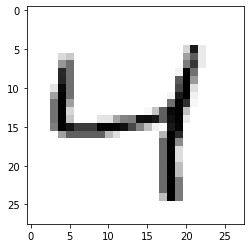

dig


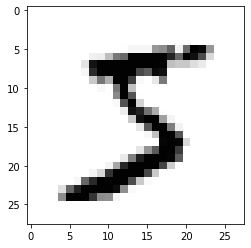

dig


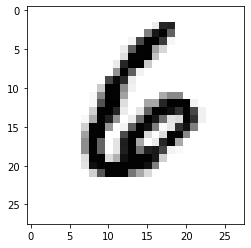

dig


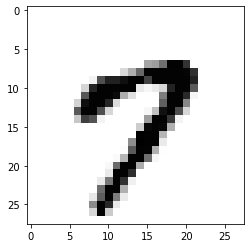

dig


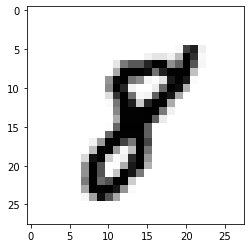

dig


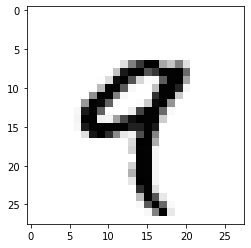

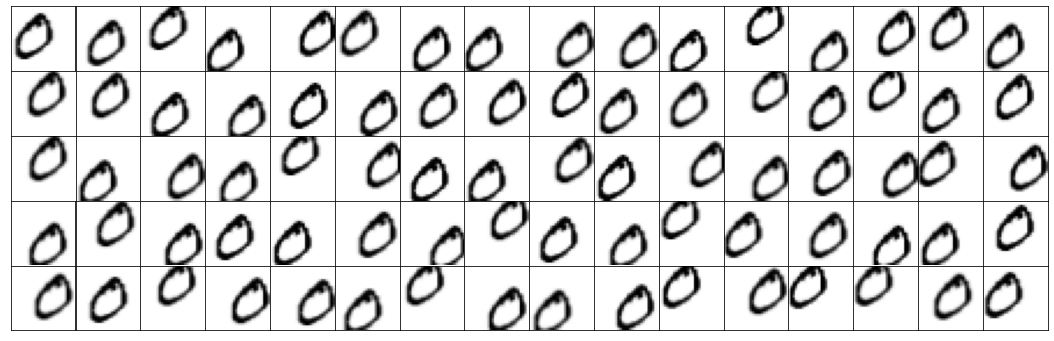

In [ ]:
B = 100
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
it = iter(dl)
y = next(it)
fig = plt.figure(figsize=(16,5))
for i in range(80):
    fig.add_subplot(5,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[i].reshape(dim,dim).cpu().numpy(), cmap="Greys")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.0,hspace=0.0)
# plt.tight_layout(h_pad=0.0,w_pad=0.0)
plt.show()
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation
it = iter(dl)
y = next(it)
fig = plt.figure(figsize=(16,5))
for i in range(80):
    fig.add_subplot(5,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[i].reshape(dim,dim).cpu().numpy(), cmap="Greys")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.0,hspace=0.0)
# plt.tight_layout(h_pad=0.0,w_pad=0.0)
plt.show()

# Training the network

In [ ]:
D

784

In [ ]:
def create_w_learning_rate_adjuster(initial_lr, final_lr, warmup_steps):
    def adjust_w_learning_rate(optimizer, step):
        if step < warmup_steps:
            t = step / warmup_steps
            lr = (1-t)*initial_lr + t*final_lr
        else:
            lr = final_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    return adjust_w_learning_rate

def create_psi_learning_rate_adjuster(initial_lr, final_lr, warmup_steps):
    def adjust_psi_learning_rate(step):
        if step < warmup_steps:
            t = step / warmup_steps
            lr = (1-t)*initial_lr + t*final_lr
        else:
            lr = final_lr
        return lr
    
    return adjust_psi_learning_rate

**Initialization**

torch.Size([10, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
dig


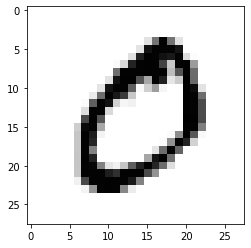

dig


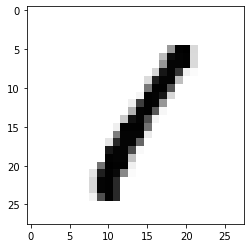

dig


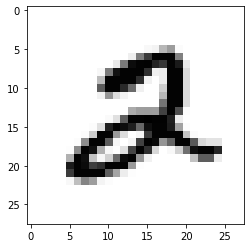

dig


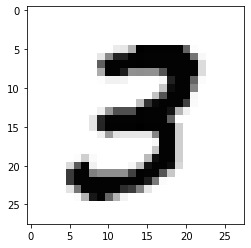

dig


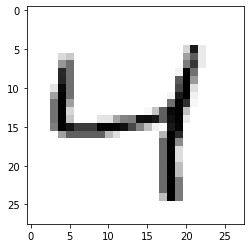

dig


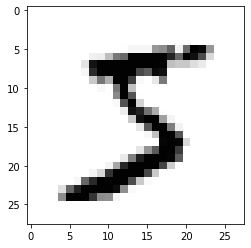

dig


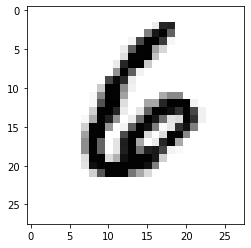

dig


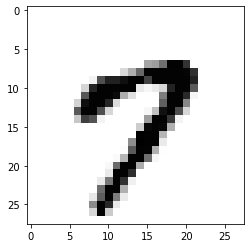

dig


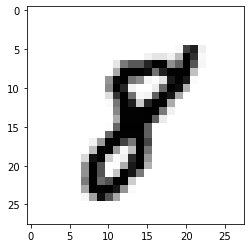

dig


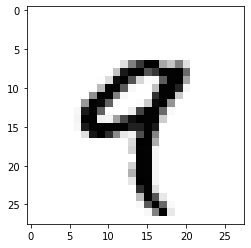

torch.Size([128, 2])


In [ ]:
B = 100

# Initialize dataloader
#dl, test_dl, dim, D, num_train_batches, num_test_batches = get_MNIST_dataloader(B,cuda=True)
#dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation
#dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True)

# Initialize omega
# L = 128
# o_max = 9.5
# multiplicity = 1
# n = 2
L = 128
o_max = 9.5
multiplicity = 1
n = 2
omega = initialize_omega(n,L,o_max,multiplicity)
print(omega.size())
assert omega.size()[0] == L

# Initialize sparse coding dictionary
K = 10
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)

# Initialize weights
pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
pre_w = lsc.orthogonalize(pre_w)
#w_manifold = geoopt.manifolds.Stiefel()
#w = geoopt.ManifoldParameter(pre_w,manifold=w_manifold,requires_grad=False)

# Initialize alpha
alpha_0 = 0.01
alpha = torch.ones(B,K).cuda()*alpha_0

k, m = None, None

epoch, T = 0, 0

In [ ]:
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,train_l=200000,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation

dl.shape

KeyboardInterrupt: ignored

**Parameters**

In [ ]:
# functions to run validation data and get score
"""def validate():
    with torch.no_grad():
        # Validation
        print('testing','reg',reg,'lr',lr)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y = next(test_it)

            # Optimize alpha
            alpha[...] = alpha_0
            alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

            # Calculate useful variables. started here before
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

            # Calculate error
            test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
            s_hat = utils.get_MAP(post) #started here before
            recon = lsc.reconstruct(x, model.w, s_hat, omega)
            torch_test_loss = torch_loss_fn(recon,y)
            torch_test_losses.append(torch_test_loss.item())
            test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
            test_l1 += alpha.norm(dim=1, p=1).mean()
            T += 1

        test_loss /= num_test_batches
        test_snr /= num_test_batches
        test_l1 /= num_test_batches
        T = 0
        print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))
        print(epoch,'mean test torch loss',np.mean(torch_test_losses))
        print('\n')"""
        
def validate():
    torch_test_losses=[]
    test_l1s=[]
    with torch.no_grad():
        print('testing','reg',reg,'lr',lr)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y_val = next(test_it)
            out_val,alpha_generated = model(y_val.view(B,1,28,28))
            total_val_loss = torch_loss_fn(out_val,y_val)
            torch_test_losses.append(total_val_loss.item())
            test_l1s.append(alpha_generated.norm(dim=1, p=1).mean().item())
            T+=1
    print('val loss',np.mean(torch_test_losses))
    print('val l1',np.mean(test_l1s))
    
def validate_linear():
    torch_test_losses=[]
    test_l1s=[]
    with torch.no_grad():
        print('testing','reg',reg,'lr',lr)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y_val = next(test_it)
            out_val,alpha_generated,s_generated = model(y_val)
            total_val_loss = torch_loss_fn(out_val,y_val)
            torch_test_losses.append(total_val_loss.item())
            test_l1s.append(alpha_generated.norm(dim=1, p=1).mean().item())
            T+=1
    print('val loss',np.mean(torch_test_losses))
    print('val l1',np.mean(test_l1s))
    
def validate_linear_occ():
    torch_test_losses=[]
    test_l1s=[]
    with torch.no_grad():
        print('testing','reg',reg,'lr',lr)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y_prev = next(test_it)
            y_val=torch.zeros_like(y_prev)
            for i in range(len(y_prev)):
                y_val[i]=erase_img(y_prev[i].reshape(28,28),7,7).reshape(784)
            out_val,alpha_generated = model(y_val)
            total_val_loss = torch_loss_fn(out_val,y_prev)
            torch_test_losses.append(total_val_loss.item())
            test_l1s.append(alpha_generated.norm(dim=1, p=1).mean().item())
            T+=1
    print('val loss',np.mean(torch_test_losses))
    print('val l1',np.mean(test_l1s))
    
def validate_conv_occ():
    torch_test_losses=[]
    test_l1s=[]
    with torch.no_grad():
        print('testing','reg',reg,'lr',lr)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y_prev = next(test_it)
            y_val=torch.zeros_like(y_prev)
            for i in range(len(y_prev)):
                y_val[i]=erase_img(y_prev[i].reshape(28,28),7,7).reshape(784)
            out_val,alpha_generated = model(y_val.view(B,1,28,28))
            total_val_loss = torch_loss_fn(out_val,y_val)
            torch_test_losses.append(total_val_loss.item())
            test_l1s.append(alpha_generated.norm(dim=1, p=1).mean().item())
            T+=1
    print('val loss',np.mean(torch_test_losses))
    print('val l1',np.mean(test_l1s))

In [ ]:
def erase_img(img,h,w):
    i = torch.randint(0, 28-h+1, size=(1, )).item()
    j = torch.randint(0, 28-w+1, size=(1, )).item()
    return tvF.erase(img,i,j,h,w,0,False)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [ ]:
# generate random transformations of random vector
class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        alpha_multiplier = torch.rand(1,K).cuda()*.0001 # (D,K)
        alpha_multiplier = torch.nn.init.xavier_uniform_(alpha_multiplier)
        self.alpha_multiplier = nn.Parameter(alpha_multiplier,requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y,s):
        #x = torch.einsum('dk,bk->bd',self.psi,alpha_multiplied) # (B,D)
        out = lsc.reconstruct(y,self.w,s,omega)
        return out

def generate_samples(s_batch,w,y):
    y_repeat=y.reshape(1,-1).repeat(s_batch.shape[0],1)
    return lsc.reconstruct(y_repeat,w,s_batch,omega)

def get_data(num_samples):
    w = torch.empty(D, L*2).cuda()
    nn.init.orthogonal_(w)
    y=torch.rand(784)-.5
    y=y.cuda()
    outputs=[]
    for batch_num in range(int(num_samples/256)):
        s_batch=(torch.rand(256,2)*2-1).cuda() # random uniform [-1,1]
        outputs.append(generate_samples(s_batch,w,y))
    return torch.cat(outputs[:-5]),torch.cat(outputs[-5:]),y,w

def get_image_data(num_samples):
    y=dl[0][0] #zero
    w = torch.empty(D, L*2).cuda()
    nn.init.orthogonal_(w)
    outputs=[]
    for batch_num in range(int(num_samples/256)):
        s_batch=(torch.rand(256,2)*2-1).cuda() # random uniform [-1,1]
        outputs.append(generate_samples(s_batch,w,y))
    return torch.cat(outputs[:-5]),torch.cat(outputs[-5:]),y,w

outputs,outputs_val,y_true,w_true=get_data(60000)

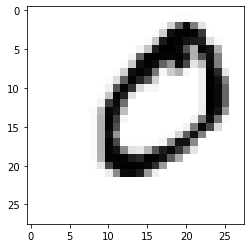

In [ ]:
plt.imshow(dl[0][0].reshape(dim,dim).cpu(), cmap="Greys")

In [ ]:
dataset=torch.utils.data.TensorDataset(outputs)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=64)
dataset_val=torch.utils.data.TensorDataset(outputs_val)
dataloader_val=torch.utils.data.DataLoader(dataset_val,batch_size=64)

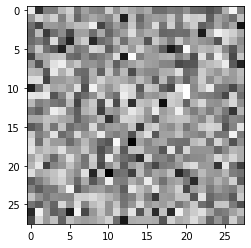

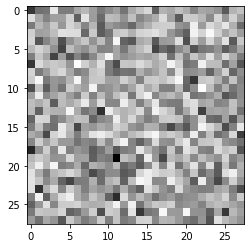

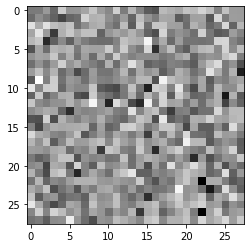

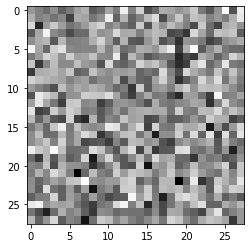

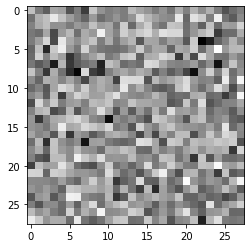

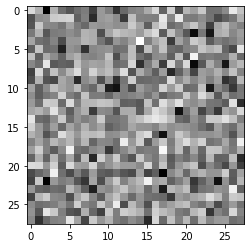

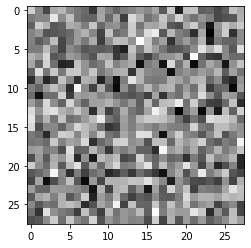

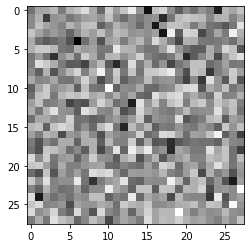

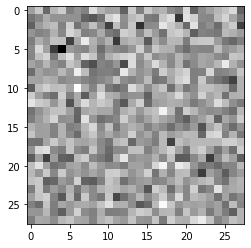

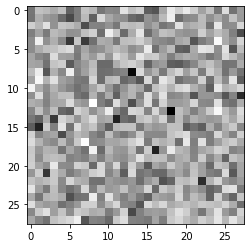

In [ ]:
data=next(iter(dataloader))[0]
for i in range(10):
    plt.imshow(data[i].reshape(dim,dim).cpu(), cmap="Greys")
    plt.show()

In [ ]:
next(iter(dataloader))[0].shape

torch.Size([64, 784])

In [ ]:
dataset[0][0].shape

torch.Size([784])

In [ ]:
# train on generated images of translation but with random template
class alpha_generator_linear(nn.Module):
    def __init__(self,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

class Model(nn.Module):
    def __init__(self,D,L,K,y_true):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear()
        self.y_true=y_true.reshape(1,-1).repeat(64,1)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        s_generated=self.alpha_gen(y)
        out = lsc.reconstruct(self.y_true,self.w,s_generated,omega)
        return out,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.003

dataset=torch.utils.data.TensorDataset(dl.reshape(100*600,784))
dataloader=torch.utils.data.DataLoader(dataset,batch_size=64)
dataset_val=torch.utils.data.TensorDataset(test_dl.reshape(100*100,784))
dataloader_val=torch.utils.data.DataLoader(dataset_val,batch_size=64)

model=Model(D,L,K,(torch.rand(dataset[0][0].shape)-.5).cuda()).cuda()
geotorch.orthogonal(model,"w")
shuffle=False



torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

for epoch in range(30):
    if epoch==8:
        for g in model_optimizer.param_groups:
            g['lr'] = 0.0001
    # Training
    losses=[]
    torch_test_losses=[]
    for i,data in enumerate(dataloader):
        y=data[0].cuda()
        if y.shape[0]!=64: continue
        out,s_generated = model(y)
        pred_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        pred_loss.backward()
        model_optimizer.step()

        losses.append(pred_loss.item())
        if np.isnan(pred_loss.item()):
            print('nan')
            break
        #print(total_loss.item())
    scheduler.step(np.mean(losses))
    if (epoch+1)%1==0:
        val_losses=[]
        with torch.no_grad():
            model.eval()
            for i,data in enumerate(dataloader_val):
                y=data[0].cuda()  
                if y.shape[0]!=64: continue  
                out,s_generated = model(y)
                pred_loss = torch_loss_fn(out,y)
                val_losses.append(pred_loss.item())
        print(epoch,'mean loss',np.mean(losses))
        print('val loss',np.mean(val_losses),'\n')
        model.train()


0 mean loss 0.0009606575182792627
val loss 0.00045619491142226767 

1 mean loss 0.0004277336345640137
val loss 0.0002823654920062743 

2 mean loss 0.0002938577618421102
val loss 0.00023765952023379027 

3 mean loss 0.00023100616148471228
val loss 0.00017494183273997923 

4 mean loss 0.00019115768591990135
val loss 0.0001631637258889476 

5 mean loss 0.00016422882938618138
val loss 0.00015524699026569485 

6 mean loss 0.00015334095948296494
val loss 0.00013182451883226467 

7 mean loss 0.00014224620080775886
val loss 0.0001385308117348289 

8 mean loss 9.362082654231212e-05
val loss 9.120377291811821e-05 

9 mean loss 9.168532284993849e-05
val loss 9.065266938425618e-05 

10 mean loss 9.112382492024686e-05
val loss 9.026173094566613e-05 

11 mean loss 9.062135792568449e-05
val loss 8.98751452087965e-05 

12 mean loss 9.008711522459743e-05
val loss 8.944607657796064e-05 



KeyboardInterrupt: ignored

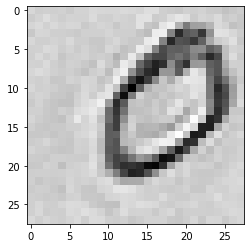

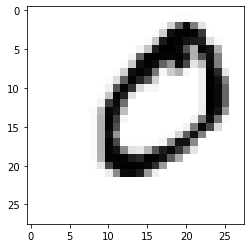

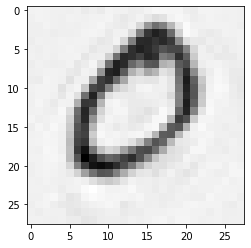

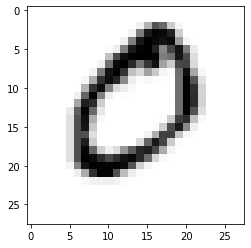

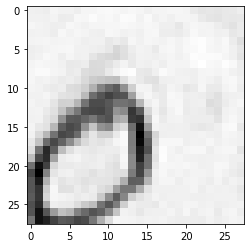

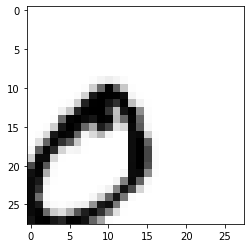

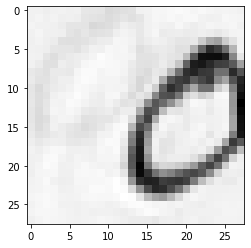

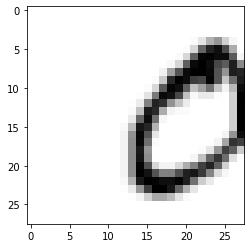

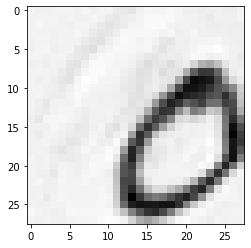

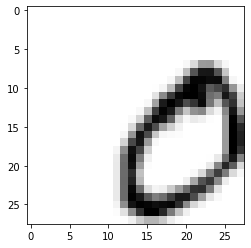

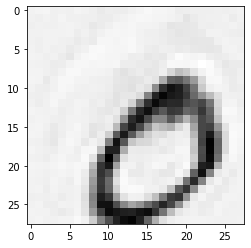

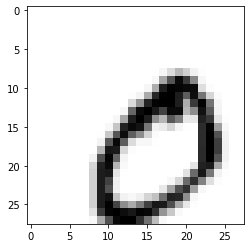

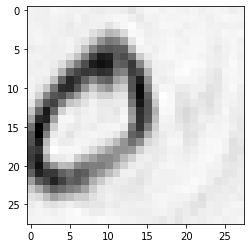

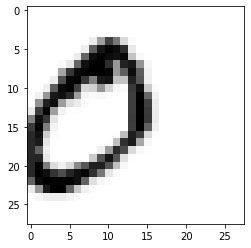

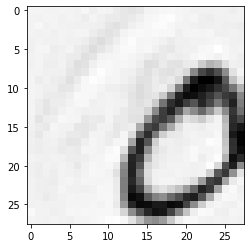

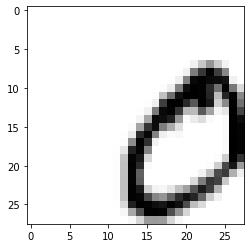

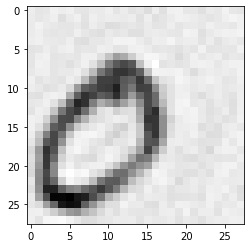

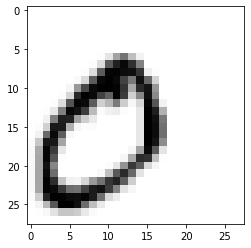

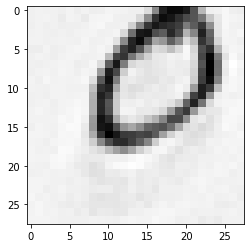

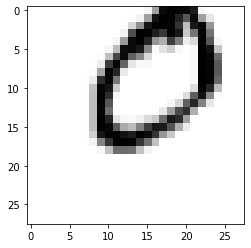

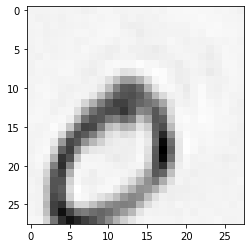

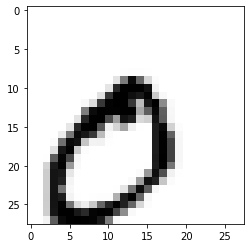

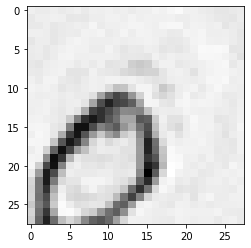

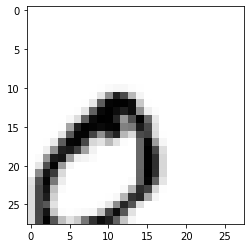

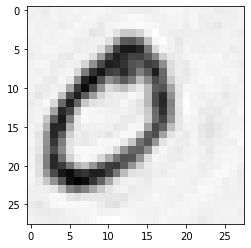

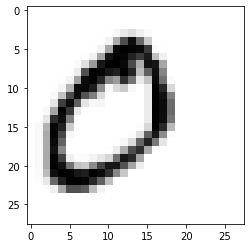

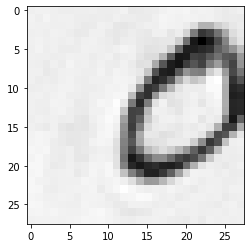

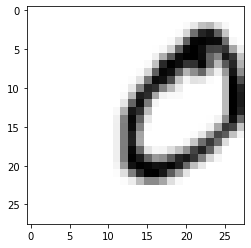

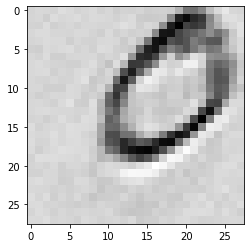

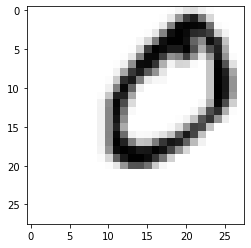

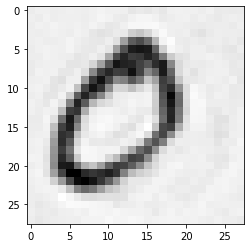

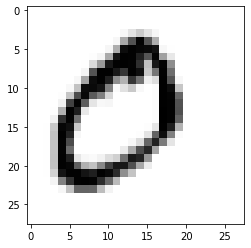

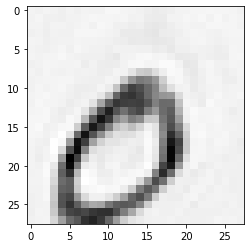

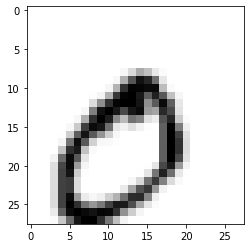

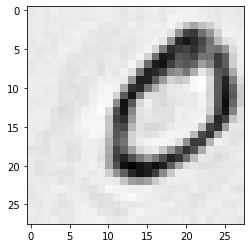

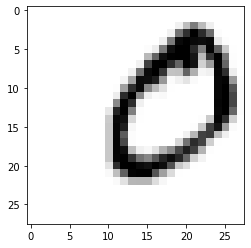

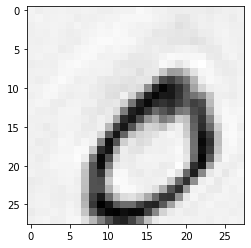

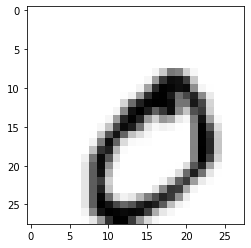

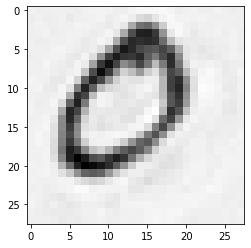

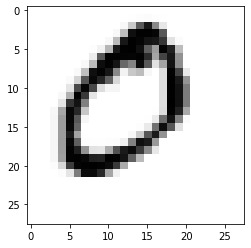

In [ ]:
data=next(iter(dataloader))[0]
out,s=model(data)
for i in range(20):
    plt.imshow(out[i].reshape(dim,dim).cpu().detach(), cmap="Greys")
    plt.show()
    plt.imshow(data[i].reshape(dim,dim).cpu().detach(), cmap="Greys")
    plt.show()
    print(' ')

In [ ]:
# train on generated images of translation
class alpha_generator_linear(nn.Module):
    def __init__(self,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

class Model(nn.Module):
    def __init__(self,D,L,K,y_true):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear()
        self.y_true=y_true.reshape(1,-1).repeat(64,1)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        s_generated=self.alpha_gen(y)
        out = lsc.reconstruct(self.y_true,self.w,s_generated,omega)
        return out,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.005

dataset=torch.utils.data.TensorDataset(dl.reshape(100*600,784))
dataloader=torch.utils.data.DataLoader(dataset,batch_size=64)
dataset_val=torch.utils.data.TensorDataset(test_dl.reshape(100*100,784))
dataloader_val=torch.utils.data.DataLoader(dataset_val,batch_size=64)

model=Model(D,L,K,dataset[0][0]).cuda()
geotorch.orthogonal(model,"w")
shuffle=False



torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

for epoch in range(30):    
    # Training
    losses=[]
    torch_test_losses=[]
    for i,data in enumerate(dataloader):
        y=data[0].cuda()
        if y.shape[0]!=64: continue
        out,s_generated = model(y)
        pred_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        pred_loss.backward()
        model_optimizer.step()

        losses.append(pred_loss.item())
        if np.isnan(pred_loss.item()):
            print('nan')
            break
        #print(total_loss.item())
    scheduler.step(np.mean(losses))
    if (epoch+1)%1==0:
        val_losses=[]
        with torch.no_grad():
            model.eval()
            for i,data in enumerate(dataloader_val):
                y=data[0].cuda()  
                if y.shape[0]!=64: continue  
                out,s_generated = model(y)
                pred_loss = torch_loss_fn(out,y)
                val_losses.append(pred_loss.item())
        print(epoch,'mean loss',np.mean(losses))
        print('val loss',np.mean(val_losses),'\n')
        model.train()


0 mean loss 0.00028076181254074327
val loss 8.980611542378589e-05 

1 mean loss 8.734383201950305e-05
val loss 4.393125912499202e-05 

2 mean loss 5.5697761483991415e-05
val loss 3.7777318982243276e-05 



KeyboardInterrupt: ignored

In [ ]:
# train on generated images
class alpha_generator_linear(nn.Module):
    def __init__(self,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

class Model(nn.Module):
    def __init__(self,D,L,K,y_true):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear()
        self.y_true=y_true.reshape(1,-1).repeat(64,1)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        s_generated=self.alpha_gen(y)
        out = lsc.reconstruct(self.y_true,self.w,s_generated,omega)
        return out,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.005

model=Model(D,L,K,y_true).cuda()
geotorch.orthogonal(model,"w")
shuffle=False


torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

for epoch in range(30):
    if epoch==6:
        for g in optim.param_groups:
            g['lr'] = 0.0005
    # Training
    losses=[]
    torch_test_losses=[]
    for i,data in enumerate(dataloader):
        y=data[0].cuda()    
        out,s_generated = model(y)
        pred_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        pred_loss.backward()
        model_optimizer.step()

        losses.append(pred_loss.item())
        if np.isnan(pred_loss.item()):
            print('nan')
            break
        #print(total_loss.item())
    scheduler.step(np.mean(losses))
    if (epoch+1)%1==0:
        val_losses=[]
        with torch.no_grad():
            model.eval()
            for i,data in enumerate(dataloader_val):
                y=data[0].cuda()    
                out,s_generated = model(y)
                pred_loss = torch_loss_fn(out,y)
                val_losses.append(pred_loss.item())
        print(epoch,'mean loss',np.mean(losses))
        print('val loss',np.mean(val_losses),'\n')
        model.train()


0 mean loss 0.0002703028597602596
val loss 0.00016531761139049195 

1 mean loss 0.00016906465135319525
val loss 0.0001333395059191389 

2 mean loss 0.00013838989811890462
val loss 0.00012264380020496902 

3 mean loss 0.0001300021048134379
val loss 0.00012795284601452295 

4 mean loss 0.00012110648217001487
val loss 0.00012551813379104714 

5 mean loss 0.00011819225043666145
val loss 0.00011118303918919992 



KeyboardInterrupt: ignored

In [ ]:
data=next(iter(dataloader))[0]
out,s=model(data)
for i in range(64):
    print(out[i][:10])
    print(data[i][:10],'\n')

tensor([-0.0231,  0.0307,  0.0176, -0.0046, -0.0046, -0.0262,  0.0064, -0.0022,
         0.0054,  0.0060], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.0400,  0.0402,  0.0097,  0.0105, -0.0118, -0.0248,  0.0148, -0.0039,
         0.0072,  0.0092], device='cuda:0') 

tensor([ 0.0349,  0.0004,  0.0249, -0.0370,  0.0171,  0.0060,  0.0022, -0.0018,
         0.0106,  0.0094], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 0.0456,  0.0228,  0.0206, -0.0348,  0.0173,  0.0173, -0.0003, -0.0080,
         0.0028,  0.0187], device='cuda:0') 

tensor([ 0.0178, -0.0040,  0.0047,  0.0165, -0.0191,  0.0035,  0.0010, -0.0024,
        -0.0061, -0.0116], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 0.0132,  0.0129, -0.0020,  0.0227, -0.0275,  0.0004, -0.0003, -0.0070,
        -0.0230, -0.0035], device='cuda:0') 

tensor([-0.0013,  0.0031,  0.0099,  0.0037,  0.0097,  0.0071, -0.0099, -0.0027,
         0.0239,  0.0104], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.0011,  0.0077, 

In [ ]:
# train on generated vectors
class alpha_generator_linear(nn.Module):
    def __init__(self,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

class Model(nn.Module):
    def __init__(self,D,L,K,y_true):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear()
        self.y_true=y_true.reshape(1,-1).repeat(64,1)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        s_generated=self.alpha_gen(y)
        out = lsc.reconstruct(self.y_true,self.w,s_generated,omega)
        return out,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.001

model=Model(D,L,K,y_true).cuda()
geotorch.orthogonal(model,"w")
shuffle=False


torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

for epoch in range(30):
    if epoch==8:
        for g in model_optimizer.param_groups:
            g['lr'] = 0.0001
    # Training
    losses=[]
    torch_test_losses=[]
    for i,data in enumerate(dataloader):
        y=data[0].cuda()    
        out,s_generated = model(y)
        pred_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        pred_loss.backward()
        model_optimizer.step()

        losses.append(pred_loss.item())
        if np.isnan(pred_loss.item()):
            print('nan')
            break
        #print(total_loss.item())
    scheduler.step(np.mean(losses))
    if (epoch+1)%1==0:
        val_losses=[]
        with torch.no_grad():
            model.eval()
            for i,data in enumerate(dataloader_val):
                y=data[0].cuda()    
                out,s_generated = model(y)
                pred_loss = torch_loss_fn(out,y)
                val_losses.append(pred_loss.item())
        print(epoch,'mean loss',np.mean(losses))
        print('val loss',np.mean(val_losses),'\n')
        model.train()


0 mean loss 0.015412615701621276
val loss 0.009610756626352667 

1 mean loss 0.009082971260207807
val loss 0.008074162458069623 

2 mean loss 0.007548908433596315
val loss 0.007286706124432385 

3 mean loss 0.006713339222664233
val loss 0.006505300453864038 

4 mean loss 0.0064978289171874395
val loss 0.006205995287746191 

5 mean loss 0.006132628252184807
val loss 0.005599578819237649 

6 mean loss 0.00585675510165066
val loss 0.00622840051073581 

7 mean loss 0.005765365623242698
val loss 0.005380594241432846 

8 mean loss 0.005154940256478843
val loss 0.004718590120319277 

9 mean loss 0.005048251450549828
val loss 0.004661474155727774 



KeyboardInterrupt: ignored

In [ ]:
data=next(iter(dataloader))[0]
out,s=model(data)
for i in range(64):
    print(out[i][:10])
    print(data[i][:10],'\n')

tensor([-0.0794,  0.0571,  0.0970,  0.0172,  0.0408,  0.0106,  0.0196, -0.0247,
        -0.0873,  0.0600], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.0894,  0.2427,  0.1817,  0.1286, -0.0788,  0.0913,  0.1010, -0.0990,
        -0.2086,  0.0434], device='cuda:0') 

tensor([-0.0569, -0.0406, -0.0234, -0.0256,  0.0240, -0.0075, -0.0290, -0.0132,
         0.0642,  0.0687], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 0.0149, -0.0342, -0.0638,  0.0440, -0.0858,  0.1384, -0.1750,  0.0022,
         0.1944,  0.1026], device='cuda:0') 

tensor([-0.0661, -0.0820,  0.0473, -0.0356,  0.1393, -0.0284,  0.1465, -0.0188,
        -0.0876,  0.0425], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-0.2812, -0.2915, -0.1007,  0.0331,  0.0801,  0.1021, -0.0090, -0.0484,
         0.0865, -0.0529], device='cuda:0') 

tensor([-0.1154, -0.0268, -0.0324, -0.0447,  0.0366, -0.1644,  0.0431, -0.0583,
         0.1152,  0.0408], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-4.1547e-02, -6.54

In [ ]:
#keep psi normalized and multiply columns by penalized constants (dot product alpha?)
class alpha_generator_linear(nn.Module):
    def __init__(self,K,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, K+s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        alpha_generated = x[:,:K]
        s_generated = x[:,K:]
        return alpha_generated,s_generated

class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        alpha_multiplier = torch.rand(1,K).cuda()*.0001 # (D,K)
        alpha_multiplier = torch.nn.init.xavier_uniform_(alpha_multiplier)
        self.alpha_multiplier = nn.Parameter(alpha_multiplier,requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        alpha_generated,s_generated=self.alpha_gen(y)
        alpha_multiplied=self.alpha_multiplier * alpha_generated
        #print('alpha',alpha_generated.shape)
        #print('s',s_generated.shape)
        #print(s_generated[:5])
        #print(alpha_generated.shape,s_generated.shape)
        #print(B,K,2)
        x = torch.einsum('dk,bk->bd',self.psi,alpha_multiplied) # (B,D)
        out = lsc.reconstruct(x,self.w,s_generated,omega)
        return out,alpha_generated,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.01
#reg=.0000001
#reg=.0000003
reg=.0000003
reg2=.0000003

for K in [8,10,12,15,20,30]:

    model=Model(D,L,K).cuda()
    geotorch.orthogonal(model,"w")
    shuffle=False


    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

    epoch=0 #lr .0002
    while epoch < 15:    
        # Training
        losses=[]
        torch_test_losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]
            #y=torch.zeros_like(y_prev)
            #for i in range(len(y_prev)):
            #    y[i]=erase_img(y_prev[i].reshape(28,28),9,9).reshape(784)
            
            out,alpha_generated,s_generated = model(y)
            l1_reg = reg * torch.norm(alpha_generated, 1)
            l1_reg2 = reg2 * torch.norm(model.alpha_multiplier,1)
            pred_loss = torch_loss_fn(out,y)
            #print(pred_loss.item())
            total_loss = pred_loss+l1_reg+l1_reg2
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()

            losses.append(pred_loss.item())
            T+=1
            if np.isnan(pred_loss.item()):
                print('nan')
                break
            #print(total_loss.item())
        scheduler.step(np.mean(losses))
        if (epoch+1)%5==0:
            #print(s_generated[:10])
            #print(alpha_generated[0])
            #print(model.alpha_multiplier)
            print(epoch,'mean loss',np.mean(losses))
            model.eval()
            validate_linear()
            model.train()
            print('\n')
        epoch+=1
    fig=plt.figure(figsize=(K,1))
    psi=model.psi.detach()
    print(model.alpha_multiplier)
    for k in range(psi.shape[1]):
        fig.add_subplot(1,K,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
    box_margins=[0.05,0.95,0.95,0.05]
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    plt.show()

4 mean loss 0.0001887813404755434
testing reg 3e-07 lr 0.01
val loss 0.0001542776766291354
val l1 0.609687723517418


9 mean loss 0.00014800858041174556
testing reg 3e-07 lr 0.01
val loss 0.0001384061800490599
val l1 0.47068786770105364


14 mean loss 0.00014193123643053697
testing reg 3e-07 lr 0.01
val loss 0.0001361988425196614
val l1 0.42944821655750276


Parameter containing:
tensor([[ 1.6956e-03, -3.6004e+00,  3.1711e+00, -3.1455e+00,  2.9654e+00,
          2.9990e+00,  3.6191e+00, -2.5265e+00]], device='cuda:0',
       requires_grad=True)


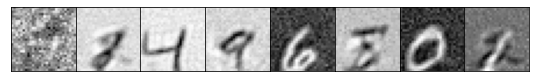

4 mean loss 0.00018697731858992482
testing reg 3e-07 lr 0.01
val loss 0.0001362974253424909
val l1 0.6483428686857223


9 mean loss 0.0001239034044313788
testing reg 3e-07 lr 0.01
val loss 0.00010715988297306467
val l1 0.49699936926364896


Epoch    15: reducing learning rate of group 0 to 1.0000e-03.
14 mean loss 0.0001186722824544025
testing reg 3e-07 lr 0.01
val loss 0.00010111252224305645
val l1 0.4590717852115631


Parameter containing:
tensor([[-3.4577e+00, -1.2789e-03,  7.5530e-04,  2.5995e+00,  3.0235e+00,
         -2.7969e+00,  2.5665e+00, -3.0505e+00, -3.5212e+00,  2.7625e+00]],
       device='cuda:0', requires_grad=True)


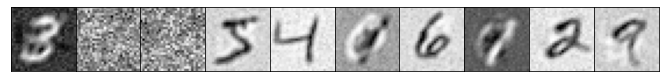

4 mean loss 0.00030696003896688734
testing reg 3e-07 lr 0.01
val loss 0.00028853833122411744
val l1 0.6516205501556397


9 mean loss 0.0001407356536704659
testing reg 3e-07 lr 0.01
val loss 0.00010640846696333028
val l1 0.5265299344062805


14 mean loss 0.00010817994076205651
testing reg 3e-07 lr 0.01
val loss 8.781602991803084e-05
val l1 0.4695283058285713


Parameter containing:
tensor([[-2.2983e+00, -2.8394e+00, -2.1357e+00,  9.1697e-04,  2.5695e+00,
          4.7484e-04,  3.8877e+00,  3.2074e+00, -3.0341e+00,  2.7562e+00,
          2.2185e-03, -2.3605e+00]], device='cuda:0', requires_grad=True)


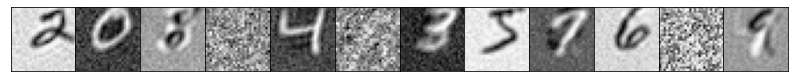

4 mean loss 0.00019028123793153403
testing reg 3e-07 lr 0.01
val loss 0.00015073805654537863
val l1 0.5798309475183487


9 mean loss 0.0001479366858014449
testing reg 3e-07 lr 0.01
val loss 0.00014097195613430814
val l1 0.4737029105424881


14 mean loss 0.0001390690238622483
testing reg 3e-07 lr 0.01
val loss 0.00013103775192575994
val l1 0.4344829523563385


Parameter containing:
tensor([[-2.7573e-03,  3.2399e+00,  1.5300e-03, -2.7207e+00, -6.3933e-05,
          3.4331e+00, -6.1372e-04,  1.3309e-03, -3.2894e+00, -3.7841e+00,
         -2.5609e+00,  7.3534e-04,  3.1037e+00,  1.2485e-03,  1.7234e-03]],
       device='cuda:0', requires_grad=True)


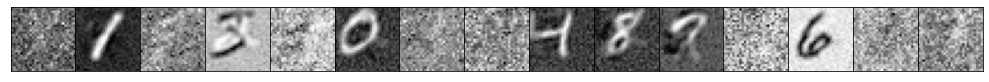

4 mean loss 0.0003228838976550226
testing reg 3e-07 lr 0.01
val loss 0.00030372834153240545
val l1 0.6673512560129166


9 mean loss 0.00015036921113884696
testing reg 3e-07 lr 0.01
val loss 0.00011188506854523439
val l1 0.5493947958946228


14 mean loss 9.61961238620764e-05
testing reg 3e-07 lr 0.01
val loss 8.293531333038118e-05
val l1 0.4783130559325218


Parameter containing:
tensor([[ 3.1506e-03,  2.0951e-03,  2.4833e+00, -2.8361e+00,  1.5475e-03,
         -2.6444e+00,  2.4238e+00, -2.8652e+00,  2.0268e-04, -1.5155e-03,
          2.5104e+00, -4.5663e+00,  3.3759e-03, -1.8178e-03, -1.3573e-03,
          2.9044e+00, -1.7611e-03, -1.1607e-03,  1.0747e-03,  2.4952e+00]],
       device='cuda:0', requires_grad=True)


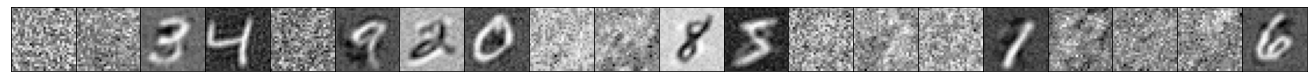

4 mean loss 0.00013526032136724098
testing reg 3e-07 lr 0.01
val loss 0.00010249979939544574
val l1 0.6730556911230088


9 mean loss 0.00010318902971145387
testing reg 3e-07 lr 0.01
val loss 8.765274673351086e-05
val l1 0.5517625927925109


Epoch    14: reducing learning rate of group 0 to 1.0000e-03.
14 mean loss 5.848789143783506e-05
testing reg 3e-07 lr 0.01
val loss 4.9060990750149355e-05
val l1 0.4629156875610352


Parameter containing:
tensor([[ 2.5319e+00,  1.8975e-04, -2.6816e+00,  8.2857e-05,  1.2680e-04,
          4.1391e+00, -2.4511e+00,  2.5817e+00, -1.7652e-04,  1.0170e-04,
          2.8391e+00,  4.9225e-05, -2.1513e-04,  6.7668e-05,  1.7542e-04,
          8.9548e-05, -2.4302e-05,  1.6824e-04,  2.8483e-05, -2.0246e-06,
         -8.7332e-06, -1.3594e-04,  2.7375e+00,  1.3479e-04,  2.5272e+00,
          1.8574e-04, -1.4943e-04,  2.3778e+00, -1.7750e-04,  2.6105e-04]],
       device='cuda:0', requires_grad=True)


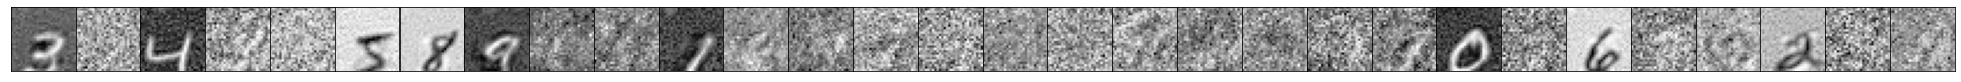

In [ ]:
#keep psi normalized and multiply columns by penalized constants (dot product alpha?)
class alpha_generator_linear(nn.Module):
    def __init__(self,K,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, K+s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        alpha_generated = x[:,:K]
        s_generated = x[:,K:]
        return alpha_generated,s_generated

class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        alpha_multiplier = torch.rand(1,K).cuda()*.0001 # (D,K)
        alpha_multiplier = torch.nn.init.xavier_uniform_(alpha_multiplier)
        self.alpha_multiplier = nn.Parameter(alpha_multiplier,requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        alpha_generated,s_generated=self.alpha_gen(y)
        alpha_multiplied=self.alpha_multiplier * alpha_generated
        #print('alpha',alpha_generated.shape)
        #print('s',s_generated.shape)
        #print(s_generated[:5])
        #print(alpha_generated.shape,s_generated.shape)
        #print(B,K,2)
        x = torch.einsum('dk,bk->bd',self.psi,alpha_multiplied) # (B,D)
        out = lsc.reconstruct(x,self.w,s_generated,omega)
        return out,alpha_generated,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.01
#reg=.0000001
#reg=.0000003
reg=.0000003
reg2=.0000003

for K in [8,10,12,15,20,30]:

    model=Model(D,L,K).cuda()
    geotorch.orthogonal(model,"w")
    shuffle=False


    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

    epoch=0 #lr .0002
    while epoch < 15:    
        # Training
        losses=[]
        torch_test_losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]
            #y=torch.zeros_like(y_prev)
            #for i in range(len(y_prev)):
            #    y[i]=erase_img(y_prev[i].reshape(28,28),9,9).reshape(784)
            
            out,alpha_generated,s_generated = model(y)
            l1_reg = reg * torch.norm(alpha_generated, 1)
            l1_reg2 = reg2 * torch.norm(model.alpha_multiplier,1)
            pred_loss = torch_loss_fn(out,y)
            #print(pred_loss.item())
            total_loss = pred_loss+l1_reg+l1_reg2
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()

            losses.append(pred_loss.item())
            T+=1
            if np.isnan(pred_loss.item()):
                print('nan')
                break
            #print(total_loss.item())
        scheduler.step(np.mean(losses))
        if (epoch+1)%5==0:
            #print(s_generated[:10])
            #print(alpha_generated[0])
            #print(model.alpha_multiplier)
            print(epoch,'mean loss',np.mean(losses))
            model.eval()
            validate_linear()
            model.train()
            print('\n')
        epoch+=1
    fig=plt.figure(figsize=(K,1))
    psi=model.psi.detach()
    print(model.alpha_multiplier)
    for k in range(psi.shape[1]):
        fig.add_subplot(1,K,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
    box_margins=[0.05,0.95,0.95,0.05]
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    plt.show()

In [ ]:
#trans no reg
class alpha_generator_linear(nn.Module):
    def __init__(self,K,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, K+s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        alpha_generated = x[:,:K]
        s_generated = x[:,K:]
        return alpha_generated,s_generated

class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        #with torch.no_grad():
        #    self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        alpha_generated,s_generated=self.alpha_gen(y)
        #print('alpha',alpha_generated.shape)
        #print('s',s_generated.shape)
        #print(s_generated[:5])
        #print(alpha_generated.shape,s_generated.shape)
        #print(B,K,2)
        x = torch.einsum('dk,bk->bd',self.psi,alpha_generated) # (B,D)
        out = lsc.reconstruct(x,self.w,s_generated,omega)
        return out,alpha_generated,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.01
#reg=.0000001
#reg=.0000003
reg=.0000003
reg2=.00001
reg2=.00005

model=Model(D,L,K).cuda()
geotorch.orthogonal(model,"w")
shuffle=False


torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

epoch=0 #lr .0002
while epoch < 100:    
    # Training
    losses=[]
    torch_test_losses=[]
    T=0
    while T < num_train_batches:
        #while T<1:
        y = dl[T]
        #y=torch.zeros_like(y_prev)
        #for i in range(len(y_prev)):
        #    y[i]=erase_img(y_prev[i].reshape(28,28),9,9).reshape(784)
        
        out,alpha_generated,s_generated = model(y)
        l1_reg = reg * torch.norm(alpha_generated, 1)
        l2_reg = reg2 * torch.norm(model.psi,2)
        pred_loss = torch_loss_fn(out,y)
        #print(pred_loss.item())
        total_loss = pred_loss+l1_reg+l2_reg
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()

        losses.append(pred_loss.item())
        T+=1
        if np.isnan(pred_loss.item()):
            print('nan')
            break
        #print(total_loss.item())
    scheduler.step(np.mean(losses))
    if (epoch)%1==0:
        print(s_generated[:10])
        print(alpha_generated[0])
        print(epoch,'mean loss',np.mean(losses))
        with torch.no_grad():
            print(torch.norm(model.psi,2))
            print(torch.norm(f.normalize(model.psi,dim=0),2))
        model.eval()
        validate_linear()
        model.train()
        print('\n')
    epoch+=1


tensor([[ 0.1499,  0.7436],
        [ 0.6835,  0.6084],
        [ 0.3081,  1.3112],
        [-0.4796,  0.0775],
        [-0.3856,  0.8807],
        [-0.1387, -0.4955],
        [-0.1955,  0.3873],
        [-0.4778,  0.3012],
        [-0.4480, -0.5000],
        [-0.4570,  0.7559]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([-2.3746e-01, -1.0858e-02, -1.0783e-01,  2.8873e-02, -1.7765e-01,
         8.6032e-01,  1.5712e-01, -8.5203e-02, -1.2274e-01, -7.2005e-04],
       device='cuda:0', grad_fn=<SelectBackward>)
0 mean loss 0.0005677146266195147
tensor(1.8701, device='cuda:0')
tensor(3.1623, device='cuda:0')
testing reg 3e-07 lr 0.01
val loss 0.00035995935439132155
val l1 2.013544212579727


tensor([[ 0.1597,  0.9480],
        [ 0.9345,  0.6759],
        [ 0.4660,  1.1661],
        [-0.3037, -0.8772],
        [-0.4398,  1.0738],
        [-0.2446, -0.6051],
        [-0.2996,  0.6111],
        [-0.5401,  0.4050],
        [-0.4843, -0.6287],
        [-0.4632,  0.9699]], device='cuda:0',

KeyboardInterrupt: ignored

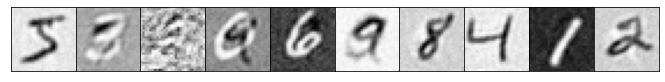

In [ ]:
fig=plt.figure(figsize=(K,1))
psi=model.psi.detach()
for k in range(psi.shape[1]):
    fig.add_subplot(1,K,k+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
box_margins=[0.05,0.95,0.95,0.05]
plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
plt.show()

4 mean loss 0.0003590725404501427
testing reg 3e-07 lr 0.01
val loss 0.0003211029939120635
val l1 0.5821661633253098


9 mean loss 0.0001868311671569245
testing reg 3e-07 lr 0.01
val loss 0.00016649639015668073
val l1 0.505015898346901


14 mean loss 0.0001754296596967227
testing reg 3e-07 lr 0.01
val loss 0.0001644726730592083
val l1 0.4911041557788849




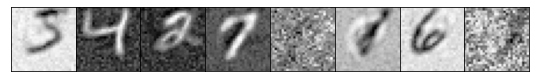

4 mean loss 0.00024087052760781566
testing reg 3e-07 lr 0.01
val loss 0.00019737643728149124
val l1 0.6388201975822448


9 mean loss 0.00018407862029562238
testing reg 3e-07 lr 0.01
val loss 0.00017756991539499722
val l1 0.5241574412584304


14 mean loss 0.00017599060622160322
testing reg 3e-07 lr 0.01
val loss 0.00017161680763820187
val l1 0.4993156653642654




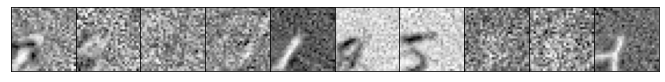

4 mean loss 0.00029599474306451156
testing reg 3e-07 lr 0.01
val loss 0.00027764267957536504
val l1 0.5494441741704941


9 mean loss 0.00027316373690458324
testing reg 3e-07 lr 0.01
val loss 0.0002643977265688591
val l1 0.4462770953774452


Epoch    14: reducing learning rate of group 0 to 1.0000e-03.
14 mean loss 0.00022607644660941635
testing reg 3e-07 lr 0.01
val loss 0.00021831239602761342
val l1 0.3985679665207863




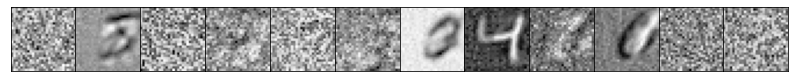

4 mean loss 0.00023459853407985066
testing reg 3e-07 lr 0.01
val loss 0.00018528494285419584
val l1 0.6444309449195862


9 mean loss 0.00016264423128935354
testing reg 3e-07 lr 0.01
val loss 0.00014947805830161086
val l1 0.5488158148527146


14 mean loss 0.00015195143372693566
testing reg 3e-07 lr 0.01
val loss 0.00014632439095294103
val l1 0.524495940208435




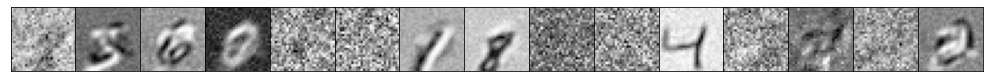

4 mean loss 0.00011760668922458233
testing reg 3e-07 lr 0.01
val loss 8.77452675922541e-05
val l1 0.6768265521526337


9 mean loss 8.583792612625984e-05
testing reg 3e-07 lr 0.01
val loss 7.825978260370902e-05
val l1 0.609230597615242


14 mean loss 7.738345697968422e-05
testing reg 3e-07 lr 0.01
val loss 6.952300187549553e-05
val l1 0.5727041298151017




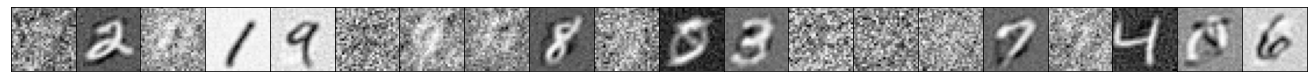

4 mean loss 0.00015758873242399812
testing reg 3e-07 lr 0.01
val loss 0.00012694454373558982
val l1 0.680673542022705


9 mean loss 0.00012358306470559909
testing reg 3e-07 lr 0.01
val loss 0.0001114239468734013
val l1 0.6112894755601883


14 mean loss 0.00011207020290991447
testing reg 3e-07 lr 0.01
val loss 0.00010411992792796809
val l1 0.5759401321411133




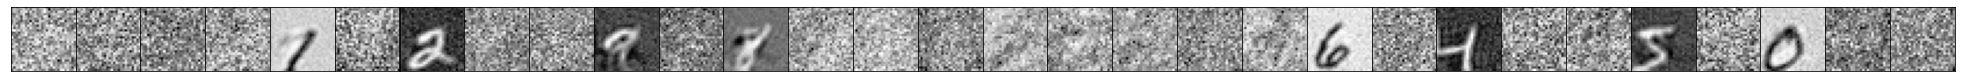

In [ ]:
#keep psi normalized and multiply columns by penalized constants (dot product alpha?)
class alpha_generator_linear(nn.Module):
    def __init__(self,K,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, K+s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        alpha_generated = x[:,:K]
        s_generated = x[:,K:]
        return alpha_generated,s_generated

class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        alpha_multiplier = torch.rand(1,K).cuda()*.0001 # (D,K)
        alpha_multiplier = torch.nn.init.xavier_uniform_(alpha_multiplier)
        self.alpha_multiplier = nn.Parameter(alpha_multiplier,requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        alpha_generated,s_generated=self.alpha_gen(y)
        alpha_multiplied=self.alpha_multiplier * alpha_generated
        #print('alpha',alpha_generated.shape)
        #print('s',s_generated.shape)
        #print(s_generated[:5])
        #print(alpha_generated.shape,s_generated.shape)
        #print(B,K,2)
        x = torch.einsum('dk,bk->bd',self.psi,alpha_multiplied) # (B,D)
        out = lsc.reconstruct(x,self.w,s_generated,omega)
        return out,alpha_generated,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.01
#reg=.0000001
#reg=.0000003
reg=.0000003
reg2=.0000006

for K in [8,10,12,15,20,30]:

    model=Model(D,L,K).cuda()
    geotorch.orthogonal(model,"w")
    shuffle=False


    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

    epoch=0 #lr .0002
    while epoch < 15:    
        # Training
        losses=[]
        torch_test_losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]
            #y=torch.zeros_like(y_prev)
            #for i in range(len(y_prev)):
            #    y[i]=erase_img(y_prev[i].reshape(28,28),9,9).reshape(784)
            
            out,alpha_generated,s_generated = model(y)
            l1_reg = reg * torch.norm(alpha_generated, 1)
            l1_reg2 = reg2 * torch.norm(model.alpha_multiplier,1)
            pred_loss = torch_loss_fn(out,y)
            #print(pred_loss.item())
            total_loss = pred_loss+l1_reg+l1_reg2
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()

            losses.append(pred_loss.item())
            T+=1
            if np.isnan(pred_loss.item()):
                print('nan')
                break
            #print(total_loss.item())
        scheduler.step(np.mean(losses))
        if (epoch+1)%5==0:
            #print(s_generated[:10])
            #print(alpha_generated[0])
            #print(model.alpha_multiplier)
            print(epoch,'mean loss',np.mean(losses))
            model.eval()
            validate_linear()
            model.train()
            print('\n')
        epoch+=1
    fig=plt.figure(figsize=(K,1))
    psi=model.psi.detach()
    for k in range(psi.shape[1]):
        fig.add_subplot(1,K,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
    box_margins=[0.05,0.95,0.95,0.05]
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    plt.show()

4 mean loss 0.00028351002520745776
testing reg 3e-07 lr 0.01
val loss 0.0002479560892970767
val l1 0.5722619599103927


9 mean loss 0.0002335782174001603
testing reg 3e-07 lr 0.01
val loss 0.00021917508158367127
val l1 0.5522219854593277


14 mean loss 0.00020909353513464643
testing reg 3e-07 lr 0.01
val loss 0.00019899849474313668
val l1 0.5350857800245286




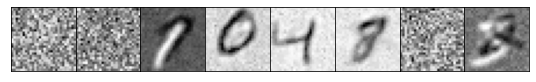

4 mean loss 0.00021905711570677038
testing reg 3e-07 lr 0.01
val loss 0.00018227412510896102
val l1 0.6835887140035629


9 mean loss 0.00017655356476704279
testing reg 3e-07 lr 0.01
val loss 0.00016357893313397653
val l1 0.6209327006340026


Epoch    15: reducing learning rate of group 0 to 1.0000e-03.
14 mean loss 0.00017622011568164454
testing reg 3e-07 lr 0.01
val loss 0.00017424455334548837
val l1 0.6086563855409622




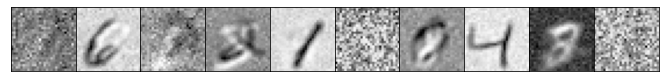

4 mean loss 0.00021243076778773684
testing reg 3e-07 lr 0.01
val loss 0.00018085691583110018
val l1 0.7104367631673812


9 mean loss 0.00018345969949829546
testing reg 3e-07 lr 0.01
val loss 0.00017004300432745366
val l1 0.6297213113307953


14 mean loss 0.00017752728575336126
testing reg 3e-07 lr 0.01
val loss 0.00017165936485980638
val l1 0.6076550650596618




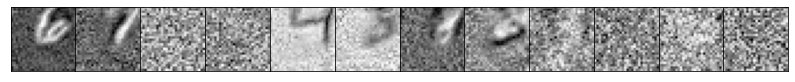

4 mean loss 0.00019337978311038265
testing reg 3e-07 lr 0.01
val loss 0.00015515436491114087
val l1 0.725060128569603


9 mean loss 0.00014708717964822426
testing reg 3e-07 lr 0.01
val loss 0.0001294977589714108
val l1 0.6603658026456833


14 mean loss 0.00013644924919693343
testing reg 3e-07 lr 0.01
val loss 0.00012217763767694123
val l1 0.6406270807981491




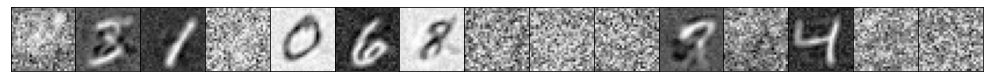

4 mean loss 0.00037057606100764437
testing reg 3e-07 lr 0.01
val loss 0.00033639043947914616
val l1 0.6334457004070282


9 mean loss 0.00023736102484690492
testing reg 3e-07 lr 0.01
val loss 0.00021597226834273896
val l1 0.5918748426437378


14 mean loss 0.00022077912784880028
testing reg 3e-07 lr 0.01
val loss 0.00020752886848640628
val l1 0.5542605823278427




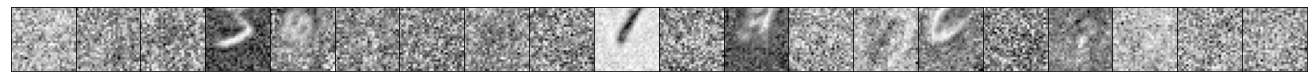

4 mean loss 0.00017955925010028297
testing reg 3e-07 lr 0.01
val loss 0.00015074318376719022
val l1 0.7677808564901352


9 mean loss 0.00014583474447135814
testing reg 3e-07 lr 0.01
val loss 0.00013772684731520714
val l1 0.6858205062150955


14 mean loss 0.00014019167555185655
testing reg 3e-07 lr 0.01
val loss 0.00012908790944493376
val l1 0.6745472657680511




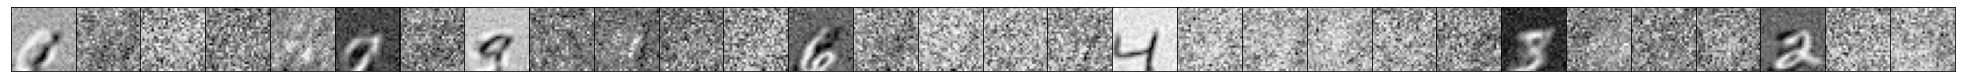

In [ ]:
#keep psi normalized and multiply columns by penalized constants (dot product alpha?)
class alpha_generator_linear(nn.Module):
    def __init__(self,K,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, K+s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        alpha_generated = x[:,:K]
        s_generated = x[:,K:]
        return alpha_generated,s_generated

class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        alpha_multiplier = torch.rand(1,K).cuda()*.0001 # (D,K)
        alpha_multiplier = torch.nn.init.xavier_uniform_(alpha_multiplier)
        self.alpha_multiplier = nn.Parameter(alpha_multiplier,requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        alpha_generated,s_generated=self.alpha_gen(y)
        alpha_multiplied=self.alpha_multiplier * alpha_generated
        #print('alpha',alpha_generated.shape)
        #print('s',s_generated.shape)
        #print(s_generated[:5])
        #print(alpha_generated.shape,s_generated.shape)
        #print(B,K,2)
        x = torch.einsum('dk,bk->bd',self.psi,alpha_multiplied) # (B,D)
        out = lsc.reconstruct(x,self.w,s_generated,omega)
        return out,alpha_generated,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.01
#reg=.0000001
#reg=.0000003
reg=.0000003
reg2=.000001

for K in [8,10,12,15,20,30]:

    model=Model(D,L,K).cuda()
    geotorch.orthogonal(model,"w")
    shuffle=False


    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

    epoch=0 #lr .0002
    while epoch < 15:    
        # Training
        losses=[]
        torch_test_losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]
            #y=torch.zeros_like(y_prev)
            #for i in range(len(y_prev)):
            #    y[i]=erase_img(y_prev[i].reshape(28,28),9,9).reshape(784)
            
            out,alpha_generated,s_generated = model(y)
            l1_reg = reg * torch.norm(alpha_generated, 1)
            l1_reg2 = reg2 * torch.norm(model.alpha_multiplier,1)
            pred_loss = torch_loss_fn(out,y)
            #print(pred_loss.item())
            total_loss = pred_loss+l1_reg+l1_reg2
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()

            losses.append(pred_loss.item())
            T+=1
            if np.isnan(pred_loss.item()):
                print('nan')
                break
            #print(total_loss.item())
        scheduler.step(np.mean(losses))
        if (epoch+1)%5==0:
            #print(s_generated[:10])
            #print(alpha_generated[0])
            #print(model.alpha_multiplier)
            print(epoch,'mean loss',np.mean(losses))
            model.eval()
            validate_linear()
            model.train()
            print('\n')
        epoch+=1
    fig=plt.figure(figsize=(K,1))
    psi=model.psi.detach()
    for k in range(psi.shape[1]):
        fig.add_subplot(1,K,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
    box_margins=[0.05,0.95,0.95,0.05]
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    plt.show()

4 mean loss 0.0002123970552687145
testing reg 3e-07 lr 0.01
val loss 0.00017674783695838413
val l1 0.5676550585031509


9 mean loss 0.00017890558107562052
testing reg 3e-07 lr 0.01
val loss 0.00016640693298541009
val l1 0.42123443812131883


Epoch    15: reducing learning rate of group 0 to 1.0000e-03.
14 mean loss 0.00017534777563317524
testing reg 3e-07 lr 0.01
val loss 0.00016028922007535584
val l1 0.38591413617134096




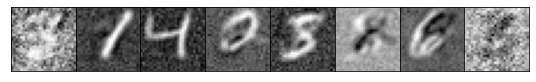

4 mean loss 0.0003181380128565555
testing reg 3e-07 lr 0.01
val loss 0.00028214376157848165
val l1 0.6470769631862641


9 mean loss 0.0001187454111520007
testing reg 3e-07 lr 0.01
val loss 9.871954694972374e-05
val l1 0.4550573033094406


14 mean loss 0.00010348297786549665
testing reg 3e-07 lr 0.01
val loss 9.596053438144736e-05
val l1 0.4209022033214569




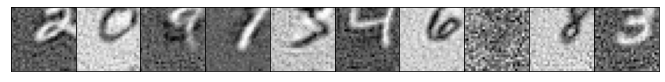

4 mean loss 0.000185992372353212
testing reg 3e-07 lr 0.01
val loss 0.00014971402793889865
val l1 0.5632420009374619


9 mean loss 0.00014508608381826586
testing reg 3e-07 lr 0.01
val loss 0.00013261749139928725
val l1 0.4382923755049706


14 mean loss 0.0001395574230021642
testing reg 3e-07 lr 0.01
val loss 0.00013749706107773818
val l1 0.3931378301978111




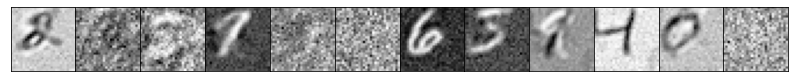

4 mean loss 0.00012808446293396022
testing reg 3e-07 lr 0.01
val loss 9.560074300679844e-05
val l1 0.5926413029432297


9 mean loss 9.611968444611799e-05
testing reg 3e-07 lr 0.01
val loss 8.485153790388722e-05
val l1 0.4689446276426315


14 mean loss 9.058906261392015e-05
testing reg 3e-07 lr 0.01
val loss 9.647281607612968e-05
val l1 0.4245531052350998




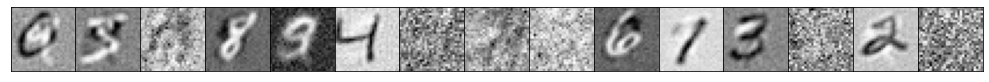

4 mean loss 0.00012331871622639785
testing reg 3e-07 lr 0.01
val loss 8.805695695627946e-05
val l1 0.5671990489959717


9 mean loss 8.891654927235019e-05
testing reg 3e-07 lr 0.01
val loss 7.574943811050616e-05
val l1 0.46748447358608247


14 mean loss 8.392685177871802e-05
testing reg 3e-07 lr 0.01
val loss 7.259397265443113e-05
val l1 0.4140013515949249




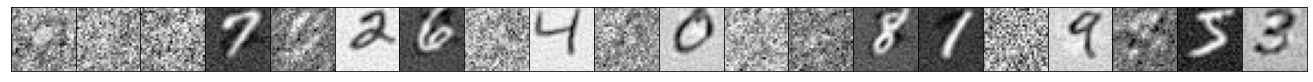

4 mean loss 0.0001267575702877366
testing reg 3e-07 lr 0.01
val loss 8.836975990561769e-05
val l1 0.5551408511400223


9 mean loss 8.822473868349335e-05
testing reg 3e-07 lr 0.01
val loss 7.570788045995868e-05
val l1 0.45609621435403824


14 mean loss 7.887131403549574e-05
testing reg 3e-07 lr 0.01
val loss 7.053923858620693e-05
val l1 0.4217001011967659




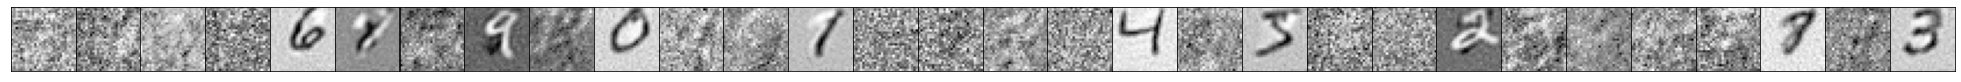

In [ ]:
#keep psi normalized and multiply columns by penalized constants (dot product alpha?)
class alpha_generator_linear(nn.Module):
    def __init__(self,K,s_size=2):
        super(alpha_generator_linear,self).__init__()
        self.fc1 = nn.Linear(784, 220)
        self.bn1 = nn.BatchNorm1d(220)
        self.fc2 = nn.Linear(220, 220)
        self.bn2 = nn.BatchNorm1d(220)
        self.fc3 = nn.Linear(220, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, K+s_size)
        
    def forward(self,x):
        x = f.relu(self.bn1(self.fc1(x)))
        x = f.relu(self.bn2(self.fc2(x)))
        x = f.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        alpha_generated = x[:,:K]
        s_generated = x[:,K:]
        return alpha_generated,s_generated

class Model(nn.Module):
    def __init__(self,D,L,K):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
        alpha_multiplier = torch.rand(1,K).cuda()*.0001 # (D,K)
        alpha_multiplier = torch.nn.init.xavier_uniform_(alpha_multiplier)
        self.alpha_multiplier = nn.Parameter(alpha_multiplier,requires_grad=True).cuda()
        self.alpha_gen=alpha_generator_linear(K)
    
    # this computes the model output given alpha and s
    def forward(self,y):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        alpha_generated,s_generated=self.alpha_gen(y)
        alpha_multiplied=self.alpha_multiplier * alpha_generated
        #print('alpha',alpha_generated.shape)
        #print('s',s_generated.shape)
        #print(s_generated[:5])
        #print(alpha_generated.shape,s_generated.shape)
        #print(B,K,2)
        x = torch.einsum('dk,bk->bd',self.psi,alpha_multiplied) # (B,D)
        out = lsc.reconstruct(x,self.w,s_generated,omega)
        return out,alpha_generated,s_generated

    def forward_s(self,alpha,s):
        x = torch.einsum('dk,bk->bd',self.psi,alpha) # (B,D)
        out = lsc.reconstruct(x,self.w,s,omega)
        return out
lr=.01
#reg=.0000001
#reg=.0000003
reg=.0000003
reg2=.0000002

for K in [8,10,12,15,20,30]:

    model=Model(D,L,K).cuda()
    geotorch.orthogonal(model,"w")
    shuffle=False


    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer,'min',verbose=True,patience=2,threshold=1e-2,cooldown=3)

    epoch=0 #lr .0002
    while epoch < 15:    
        # Training
        losses=[]
        torch_test_losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]
            #y=torch.zeros_like(y_prev)
            #for i in range(len(y_prev)):
            #    y[i]=erase_img(y_prev[i].reshape(28,28),9,9).reshape(784)
            
            out,alpha_generated,s_generated = model(y)
            l1_reg = reg * torch.norm(alpha_generated, 1)
            l1_reg2 = reg2 * torch.norm(model.alpha_multiplier,1)
            pred_loss = torch_loss_fn(out,y)
            #print(pred_loss.item())
            total_loss = pred_loss+l1_reg+l1_reg2
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()

            losses.append(pred_loss.item())
            T+=1
            if np.isnan(pred_loss.item()):
                print('nan')
                break
            #print(total_loss.item())
        scheduler.step(np.mean(losses))
        if (epoch+1)%5==0:
            #print(s_generated[:10])
            #print(alpha_generated[0])
            #print(model.alpha_multiplier)
            print(epoch,'mean loss',np.mean(losses))
            model.eval()
            validate_linear()
            model.train()
            print('\n')
        epoch+=1
    fig=plt.figure(figsize=(K,1))
    psi=model.psi.detach()
    for k in range(psi.shape[1]):
        fig.add_subplot(1,K,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
    box_margins=[0.05,0.95,0.95,0.05]
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    plt.show()